In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [29]:
# Load datasets
sales = pd.read_csv('../data/cleaned/Cleaned_Sales.csv')[['OrderNumber', 'ProductKey']]
products = pd.read_csv('../data/cleaned/Cleaned_Products.csv')[['ProductKey', 'ProductSubcategoryKey']]
subcats = pd.read_csv('../data/cleaned/Cleaned_Product_Subcategories.csv')[['ProductSubcategoryKey', 'SubcategoryName']]

# Merge data logic: Sales -> Products -> Subcategories
df = sales.merge(products, on='ProductKey', how='left') \
          .merge(subcats, on='ProductSubcategoryKey', how='left')

# Optional: Keep only the columns needed for Association Rule Mining
df = df[['OrderNumber', 'SubcategoryName']]

In [30]:
df= df.dropna()
df= df.reset_index(drop= True)

In [31]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [32]:
len(df['OrderNumber'].unique())

22534

In [33]:
c= df.groupby('OrderNumber')['SubcategoryName'].apply(list)

In [34]:
te= TransactionEncoder()
basket= te.fit_transform(c)
basket= pd.DataFrame(basket, columns= te.columns_)

In [35]:
basket

,Bike Racks,Bike Stands,Bottles and Cages,Caps,Cleaners,Fenders,Gloves,Helmets,Hydration Packs,Jerseys,Mountain Bikes,Road Bikes,Shorts,Socks,Tires and Tubes,Touring Bikes,Vests
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22529,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
22530,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
22531,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
22532,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


### Data Mining

In [36]:
fi= apriori(basket, min_support=.01, use_colnames= True)
fi.head()

,support,itemsets
0,0.012204,(Bike Racks)
1,0.175468,(Bottles and Cages)
2,0.080767,(Caps)
3,0.033194,(Cleaners)
4,0.076595,(Fenders)


In [37]:
fi.shape

(54, 2)

In [38]:
fi['itemsets']= fi['itemsets'].apply(lambda x: x if len(x)== 2 else None)
fi= fi.dropna()
top_pairs= fi.sort_values('support', ascending= False)
top_pairs.head()

,support,itemsets
43,0.091506,"(Tires and Tubes, Helmets)"
42,0.051966,"(Helmets, Road Bikes)"
19,0.043623,"(Helmets, Bottles and Cages)"
23,0.037810,"(Road Bikes, Bottles and Cages)"
22,0.036212,"(Bottles and Cages, Mountain Bikes)"


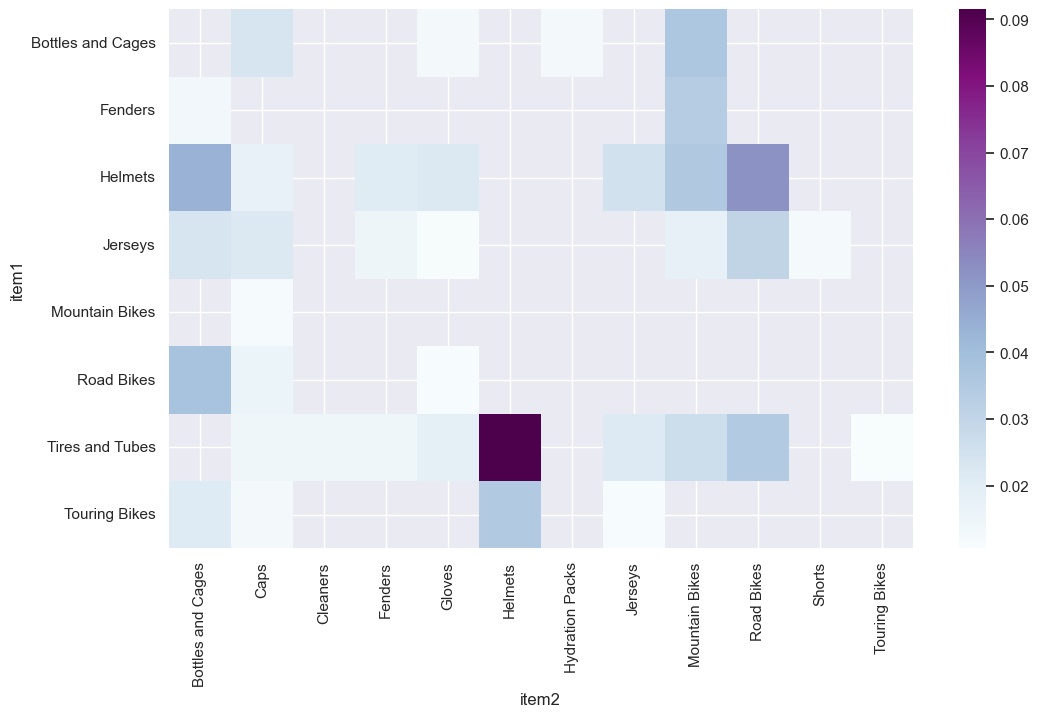

In [39]:
top_pairs['item1'] = top_pairs['itemsets'].apply(lambda x: list(x)[0])
top_pairs['item2'] = top_pairs['itemsets'].apply(lambda x: list(x)[1])
heatmap= pd.crosstab(top_pairs['item1'], top_pairs['item2'], values= top_pairs['support'], aggfunc= 'mean',
                     dropna= True)
plt.figure(figsize= (12 ,7))
sns.heatmap(heatmap, cmap= 'BuPu')
plt.show()

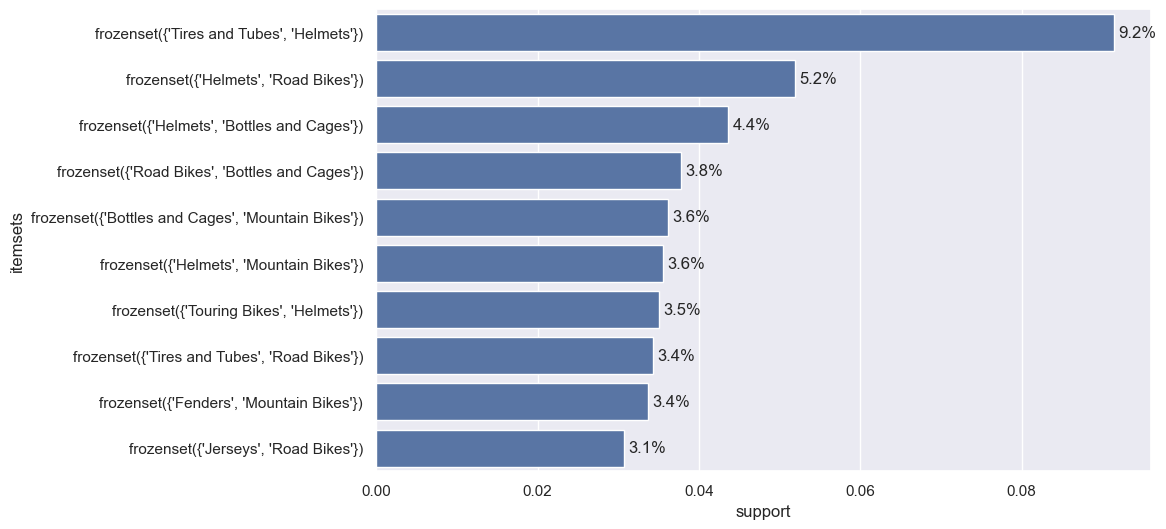

In [40]:
# Sorting and selecting top 10
fi_top10 = fi.sort_values('support', ascending=False).head(10)


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=fi_top10, x='support', y='itemsets')

# Create percentage labels (e.g., 0.054 -> 5.4%)
labels = [f'{val*100:.1f}%' for val in fi_top10['support']]

# Use padding to push text to the right of the bar
ax.bar_label(ax.containers[0], labels=labels, padding=3)
plt.show()

In [41]:
fi3= apriori(basket, min_support=.01, use_colnames= True)
fi3['itemsets']= fi3['itemsets'].apply(lambda x: x if len(x)== 3 else None)
fi3= fi3.dropna()
fi3.head()

,support,itemsets
53,0.010872,"(Helmets, Bottles and Cages, Mountain Bikes)"


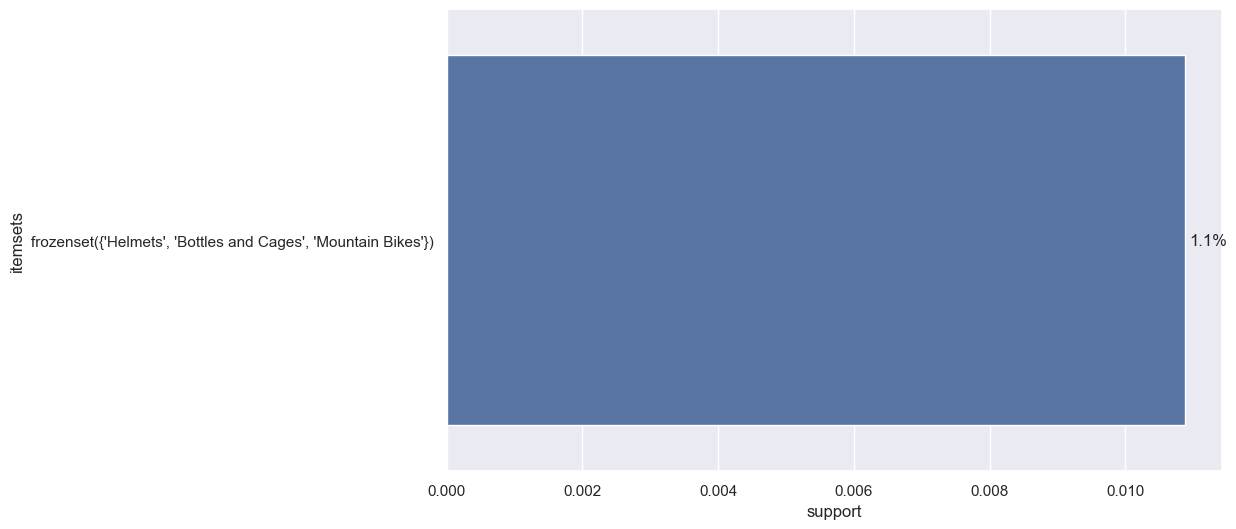

In [43]:
# Sorting and selecting top 10
fi3_top10 = fi3.sort_values('support', ascending=False).head(10)


plt.figure(figsize=(10, 6))
ax = sns.barplot(data=fi3_top10, x='support', y='itemsets')

# Create percentage labels (e.g., 0.054 -> 5.4%)
labels = [f'{val*100:.1f}%' for val in fi3_top10['support']]

# Use padding to push text to the right of the bar
ax.bar_label(ax.containers[0], labels=labels, padding=3)
plt.show()

**model training**

In [45]:
fi= apriori(basket, min_support=.01, use_colnames= True)
ar= association_rules(fi, metric= 'lift', min_threshold=1)
ar= ar.iloc[:,:7]
ar= ar.sort_values('lift', ascending= False)

In [52]:
# # combine lift and conf to come up with rules (lift > 1, conf > 20% or more)
# Jerseys & Shorts (Lift: 2.66, Conf: 32%): This is your strongest link. 1 in 3 people who buy shorts also buy a jersey.
# Hydration Packs & Bottles (Lift: 2.63, Conf: 46%): This is a "Gold Mine." Nearly half of the people buying a hydration pack also get a bottle/cage.
# Fenders & Mountain Bikes (Lift: 2.31, Conf: 44%): This is highly actionable. If someone buys a fender, there is a 44% chance they are buying a bike too.
ar.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
38,(Jerseys),(Shorts),0.121328,0.037055,0.011982,0.098756,2.665122
39,(Shorts),(Jerseys),0.037055,0.121328,0.011982,0.323353,2.665122
9,(Hydration Packs),(Bottles and Cages),0.027381,0.175468,0.012648,0.461912,2.632457
8,(Bottles and Cages),(Hydration Packs),0.175468,0.027381,0.012648,0.072079,2.632457
27,(Mountain Bikes),(Fenders),0.190024,0.076595,0.033682,0.177254,2.314156


In [59]:
# 1. Filter for high Confidence and Lift
significant_rules = ar[(ar['confidence'] > 0.3) & (ar['lift'] > 1)].copy()

# 2. Remove redundant 'swapped' rules (A->B and B->A)
# We sort the antecedents/consequents to identify duplicates
significant_rules['subset'] = significant_rules.apply(
    lambda x: frozenset(x['antecedents'] | x['consequents']), axis=1
)
significant_rules = significant_rules.drop_duplicates(subset=['subset'])

# 3. Drop the helper column and view results
significant_rules = significant_rules.drop(columns=['subset'])

In [ ]:
significant_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
39,(Shorts),(Jerseys),0.037055,0.121328,0.011982,0.323353,2.665122
9,(Hydration Packs),(Bottles and Cages),0.027381,0.175468,0.012648,0.461912,2.632457
26,(Fenders),(Mountain Bikes),0.076595,0.190024,0.033682,0.439745,2.314156
36,(Touring Bikes),(Helmets),0.082764,0.238484,0.035014,0.423056,1.773939
29,(Gloves),(Helmets),0.052321,0.238484,0.022056,0.421544,1.767597
43,"(Helmets, Mountain Bikes)",(Bottles and Cages),0.035546,0.175468,0.010872,0.305868,1.743152
21,(Cleaners),(Tires and Tubes),0.033194,0.318718,0.014423,0.434492,1.363247
35,(Helmets),(Tires and Tubes),0.238484,0.318718,0.091506,0.383699,1.203882
33,(Gloves),(Tires and Tubes),0.052321,0.318718,0.019038,0.363868,1.141659


: 